#### надо установить opencv для python, если не установлен.
#### pip(pip3) install opencv-python

In [1]:
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': '30',
         'axes.titlesize':'35',
         'xtick.labelsize':'30',
         'ytick.labelsize':'30'}
pylab.rcParams.update(params)

Пример получения вектора признаков для изображения

In [2]:
# далее задаются параметры HOG-a, они выставлены как в статье.
win_size = (64,128) 
block_size = (16,16)
block_stride = (8,8)
cell_size = (8,8)
nbins = 9
deriv_aperture = 1
win_sigma = -1
histogram_norm_type = 0
l2_hys_threshold = 2.0000000000000001e-01
gamma_correction = 0
nlevels = 64
hog = cv2.HOGDescriptor(win_size,block_size,block_stride,cell_size,nbins,deriv_aperture,win_sigma,
                        histogram_norm_type,l2_hys_threshold,gamma_correction,nlevels)


В базе INRIA размер изображений содержащих пешеходов  - 96х160(train) и 70x134(test). Человек расположен по центру.

Вам нужно получить вектор признаков(дескриптор) для окна 64х128. По умолчанию compute() строит дескрипторы для всех окон размером 64х128 методом скользящего окна, с шагом win_stride по обеим осям. Но если вам нужно получить дескриптор только для одного окна 64х128, то у метода есть аргумент locations, в котором можно передать координаты верхнего левого угла интересующего вас окна (либо список таких координат)

Например, для изображений из train извлечение центрального окна 64х128 выглядит следующим образом:

In [3]:
img = cv2.imread("crop_000010a.png")
height, width = img.shape[:2]
locations = [((width-64)//2, (height-128)//2)]
descriptor = hog.compute(img, locations=locations)
descriptor.size

3780

Изображения фона(отрицательные примеры)  - изображения произвольного размера. В обучающей выборке их 1218. Авторы HOG для обучения выбирали рандомно 10 окон 64х128 из каждого изображения  - всего 12180 примеров, не содержащих пешеходов.

Для этого, например, можно посчитать дескрипторы по всему изображению с win_stride=(4,4) и потом рандомно выбрать 10 из них.

Такие манипуляции вам надо проделать в цикле со всеми изображениями из train: для изображений из папки pos/ выбирать центральное окно, а из папки neg/ - 10 рандомных окон. Собрать их в np.array  или список, как вам будет удобно ну и в файл сохранить тоже.

Для того чтобы получить ответ svm классификатора у класса HOGDescriptor есть метод detect(). Этот метод вам понадобится, чтобы строить кривые качества (DET кривые). Метод detect() работает похожим образом с compute().
Только перед его использованием нужно задать веса SVM:

    hog.setSVMDetector(hog.getDefaultPeopleDetector()) - используется веса из opencv для HOG, обученного на INRIA
В остальном поробуйте сами с detect() разобраться. Если не получится - пишите.

Гайд по построению DET кривых позже добавлю

# Выделим признаки на позитивных картинках

In [4]:
win_stride = (8,8) #шаг скользящего окна в пикселях по ширине и высоте
def imHOG(path_to_image):
    img = cv2.imread(path_to_image)
    height, width = img.shape[:2]
    locations = [((width-64)//2, (height-128)//2)]
    descriptor = hog.compute(img, locations=locations)
    return descriptor

In [5]:
import pandas as pd

images = open("pos.lst")
string = images.read()
images = string.split("\n")
for i in range(len(images)):
    images[i] = images[i][10:]
images = images[:-1]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
pos = []
for i in range(len(images)):
    #desc_file.write(str(imHOG(images[i]))+"\n")
    descriptor_current = imHOG(images[i])
    pos.append(descriptor_current)

In [7]:
images = open("pos_test.lst")
string = images.read()
images = string.split("\n")
for i in range(len(images)):
    images[i] = images[i][9:]
images = images[:-1]


In [8]:
pos_test = []
for i in range(len(images)):
    #desc_file.write(str(imHOG(images[i]))+"\n")
    descriptor_current = imHOG(images[i])
    pos_test.append(descriptor_current)

# На негативных

In [9]:
win_stride = (8,8) #шаг скользящего окна в пикселях по ширине и высоте
def imHOG_neg(path_to_image):
    img = cv2.imread(path_to_image)
    win_stride = (4,4)
    #получаем дескрипторы изображения и приводим их к рамеру
    #(кол-во окон на изображении)х(рамер дескриптора одного окна)
    #рамер дексриптора для параметров HOG как в статье - 3780
    descriptors = hog.compute(img, win_stride).reshape(-1,3780)
    indexes = np.random.randint(descriptors.shape[0], size=10)
    ten_random_samples = descriptors[indexes]
    return ten_random_samples

In [10]:
images_neg = open("neg.lst")
string_neg = images_neg.read()
images_neg = string_neg.split("\n")
for i in range(len(images_neg)):
    images_neg[i] = images_neg[i][10:]
images_neg = images_neg[:-1]


In [11]:
neg = []
for i in range(int(len(images_neg))): 
    desc_hog = imHOG_neg(images_neg[i])
    for i in range (len(desc_hog)):
        neg.append(desc_hog[i])

In [12]:
images_neg = open("neg_test.lst")
string_neg = images_neg.read()
images_neg = string_neg.split("\n")
for i in range(len(images_neg)):
    images_neg[i] = images_neg[i][9:]
images_neg = images_neg[:-1]

In [13]:
neg_test = []
for i in range(int(len(images_neg))):   
    desc_hog = imHOG_neg(images_neg[i])
    for descriptor_current in desc_hog:
        neg_test.append(descriptor_current)

# Решейпим полученные дескрипторы pos, pos_test, neg, neg_test

In [14]:
print(len(neg),len(neg_test),len(pos),len(pos_test))

12180 4530 2416 1132


In [15]:
for i in range(len(pos)):
    for j in range(3780):
        pos[i][j] = pos[i][j][0]
        
for i in range(len(pos_test)):
    for j in range(3780):
        pos_test[i][j] = pos_test[i][j][0]

In [5]:

def Reshape_in(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array with 14 elem
        for j in range(0,15):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,7):
                b.append(Q[2*j*14*9+k*36+i])
                b.append(Q[2*j*14*9+k*36+i+18])
                c.append(Q[2*j*14*9+k*36+i+9])
                c.append(Q[2*j*14*9+k*36+i+27])
            a.append(b)
            a.append(c)
        RES.append(a)
    return RES
def Reshape_in1(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array with 14 elem
        for j in range(0,15):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,7):
                b.append(Q[2*j*14*9+k*36+i])
                b.append(Q[2*j*14*9+k*36+i+9])
                c.append(Q[2*j*14*9+k*36+i+18])
                c.append(Q[2*j*14*9+k*36+i+27])
            a.append(b)
            a.append(c)
        RES.append(a)
    return RES


In [45]:
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim


class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)    9x30x14
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(9, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(18, 36, kernel_size=5, stride=1, padding=1)
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(36 * 14 * 6, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 1)
        #self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)   9x30x14 to 18x30x14
        x = F.relu(self.conv1(x))
        #print(x.shape)
        #print(x.shape)
        #to 18x14x6
        x = F.relu(self.conv2(x))   #to 36x14x6
        #print(x.shape)
        #print(x.shape)
        #Size changes from (18, 32, 32) to (18, 16, 16)  36x14x6 to 36x7x3
        x = self.pool(x)
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        #print(x.shape)
        x = x.view(-1, 36 * 14 * 6)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return F.sigmoid(x)

model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

# Train the model
for i in range(800):
    # Forward pass
    #xinput = torch.tensor(Reshape_in(neg[i]), dtype = torch.float32)
    inputs = []
    labels = []
    for j in range(3):
        inputs.append(Reshape_in(neg[9*i+3*j]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+1]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+2]))
        labels.append([0])
        inputs.append(Reshape_in(pos[3*i+j]))
        labels.append([1])
    inputs = torch.from_numpy(np.array(inputs))
    labels = torch.tensor(labels, dtype = torch.float32)
    #print(inputs.shape, labels)

    outputs = model(inputs)
    #print(outputs)

    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        print ('Loss: {:.4f}' 
               .format(loss.item()))



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.6101
Loss: 0.6607
Loss: 0.0636
Loss: 0.3394


## $$FNR = \frac{FN}{FN+TP}$$     
$$ FPR = \frac{FP}{FP+TN} $$

In [68]:
#det FNR(FPR)
inputs = []
labels = []
for i in range(1100):

    inputs.append(Reshape_in(neg_test[2*i]))
    labels.append([0])
    inputs.append(Reshape_in(neg_test[2*i+1]))
    labels.append([0])
    inputs.append(Reshape_in(pos_test[i]))
    labels.append([1])
inputs = torch.from_numpy(np.array(inputs))
labels = torch.tensor(labels, dtype = torch.float32)
outputs = model(inputs)







/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [69]:
def det(neg_test, pos_test, h):

    fn = 0
    tp = 0
    fp = 0
    tn = 0
    
    for j in range(len(inputs)):
        if outputs[j] > h:
            if labels[j] == 1:
                tp += 1
            if labels[j] == 0:
                fn += 1
        else:
            if labels[j] == 0:
                tn += 1
            if labels[j] == 1:
                fp += 1
    if(fn+tp & fp+tn):
        fnr = fn/(fn+tp)
        fpr = fp/(fp+tn)
    else:
        fnr=0
        fpr=0
    return fnr, fpr


fpr = []  #x
fnr = []  #y

for h in np.linspace(0.1, 0.9, 200):
    y,x = det(neg_test, pos_test, h)
    fpr.append(x)
    fnr.append(y)
    #print(h)

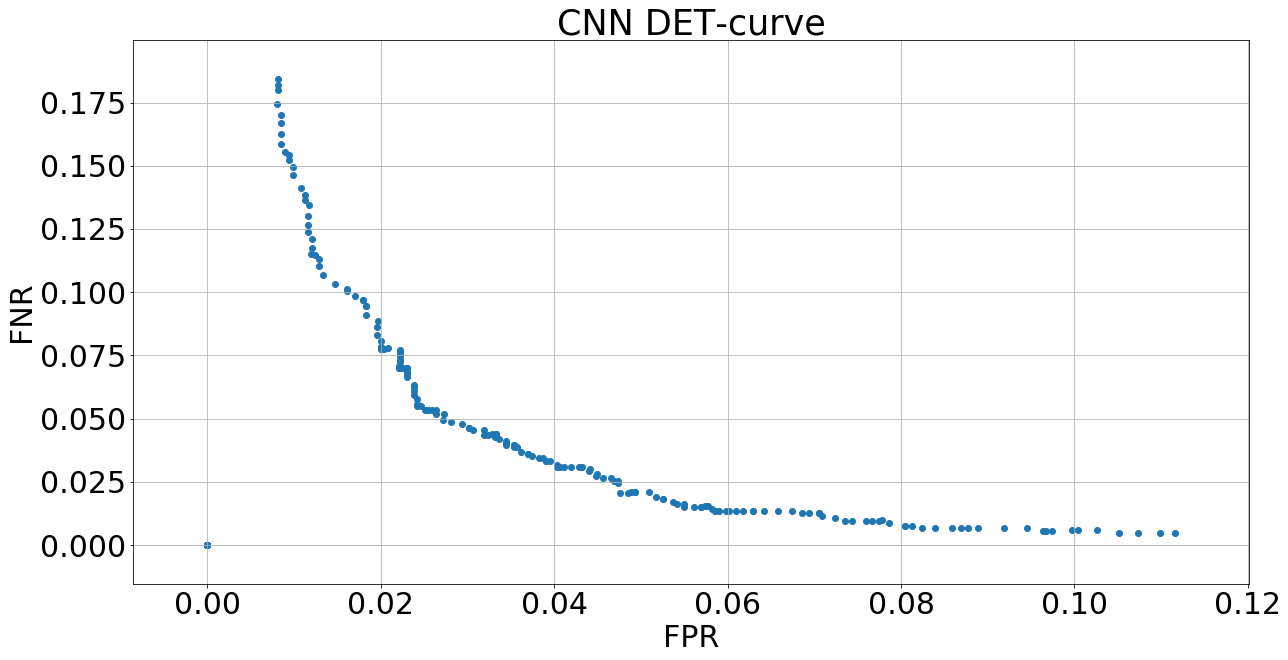

In [76]:
#plt.figure(figsize=(20,10))
plt.title("CNN DET-curve")
plt.scatter(fpr, fnr)
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.grid()

## MORE MAXPOLLING

In [55]:
class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)    9x30x14
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(9, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(18, 36, kernel_size=5, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(36 * 2 * 6, 64)
        self.fc2 = torch.nn.Linear(64, 1)
        #self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))   
        x = self.pool(x)
        #print(x.size())
        x = x.view(-1, 36 * 2 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)

model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

# Train the model
for i in range(800):
    inputs = []
    labels = []
    for j in range(3):
        inputs.append(Reshape_in(neg[9*i+3*j]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+1]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+2]))
        labels.append([0])
        inputs.append(Reshape_in(pos[3*i+j]))
        labels.append([1])
    inputs = torch.from_numpy(np.array(inputs))
    labels = torch.tensor(labels, dtype = torch.float32)
    #print(inputs.shape, labels)
    outputs = model(inputs)
    #print(outputs)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        print ('Loss: {:.4f}' 
               .format(loss.item()))




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.5608
Loss: 0.8608
Loss: 0.2442
Loss: 0.4755


## LINERAL 

In [64]:
class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)    9x30x14
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(3780, 128)
        self.fc2 = torch.nn.Linear(128, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        #self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        #print(x.size())
        x = x.view(-1, 9*30*14)
        x = self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        return F.sigmoid(x)

model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

# Train the model
for i in range(800):
    inputs = []
    labels = []
    for j in range(3):
        inputs.append(Reshape_in(neg[9*i+3*j]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+1]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+2]))
        labels.append([0])
        inputs.append(Reshape_in(pos[3*i+j]))
        labels.append([1])
    inputs = torch.from_numpy(np.array(inputs))
    labels = torch.tensor(labels, dtype = torch.float32)
    #print(inputs.shape, labels)
    outputs = model(inputs)
    #print(outputs)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        print ('Loss: {:.4f}' 
               .format(loss.item()))




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.5779
Loss: 0.1240
Loss: 0.0006
Loss: 0.1359


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.7213
Loss: 0.7213
Loss: 0.7227
Loss: 0.7227


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Проверим на вшивость

In [3]:
def subl_nbins(h):
    fig, ((ax1, ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3 , figsize=(20, 10), sharex=True, sharey=True)
    print(h[0][:][:].shape)
    ax1.axis('off')
    ax1.imshow(h[0])
    ax1.set_title('0-20')
    
    ax2.axis('off')
    ax2.imshow(h[1])
    ax2.set_title('20-40')
    
    ax3.axis('off')
    ax3.imshow(h[2])
    ax3.set_title('40-60')
    
    ax4.axis('off')
    ax4.imshow(h[3])
    ax4.set_title('60-80')
    
    ax5.axis('off')
    ax5.imshow(h[4])
    ax5.set_title('80-100')
    
    ax6.axis('off')
    ax6.imshow(h[5])
    ax6.set_title('100-120')
    
    ax7.axis('off')
    ax7.imshow(h[6])
    ax7.set_title('120-140')
    
    ax8.axis('off')
    ax8.imshow(h[7])
    ax8.set_title('140-160')
    
    ax9.axis('off')
    ax9.imshow(h[8])
    ax9.set_title('160-180')
    # Rescale histogram for better display
    
    

In [4]:
def Reshape_in(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array with 14 elem
        for j in range(0,15):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,7):
                b.append(Q[2*j*14*9+k*36+i])
                b.append(Q[2*j*14*9+k*36+i+18])
                c.append(Q[2*j*14*9+k*36+i+9])
                c.append(Q[2*j*14*9+k*36+i+27])
            a.append(b)
            a.append(c)
        RES.append(a)
    return RES
def Reshape_in_(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array with 14 elem
        for j in range(0,7):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,15):
                b.append(Q[2*j*30*9+k*36+i])
                b.append(Q[2*j*30*9+k*36+i+18])
                c.append(Q[2*j*30*9+k*36+i+9])
                c.append(Q[2*j*30*9+k*36+i+27])
            a.append(b)
            a.append(c)
        RES.append(a)
        return RES
def Reshape_in__(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array with 14 elem
        for j in range(0,7):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,15):
                b.append(Q[2*j*30*9+k*36+i])
                b.append(Q[2*j*30*9+k*36+i+9])
                c.append(Q[2*j*30*9+k*36+i+27])
                c.append(Q[2*j*30*9+k*36+i+18])
            a.append(b)
            a.append(c)
        RES.append(a)
    return RES


def Reshape_in1(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array with 14 elem
        for j in range(0,7):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,15):
                b.append(Q[2*j*30*9+k*36+i])
                b.append(Q[2*j*30*9+k*36+i+9])
                c.append(Q[2*j*30*9+k*36+i+18])
                c.append(Q[2*j*30*9+k*36+i+27])
            a.append(b)
            a.append(c)
        RES.append(a)
    return RES




[0.]
0.0
(9, 30, 14)
(30, 14)
(14, 30)


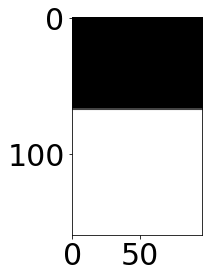

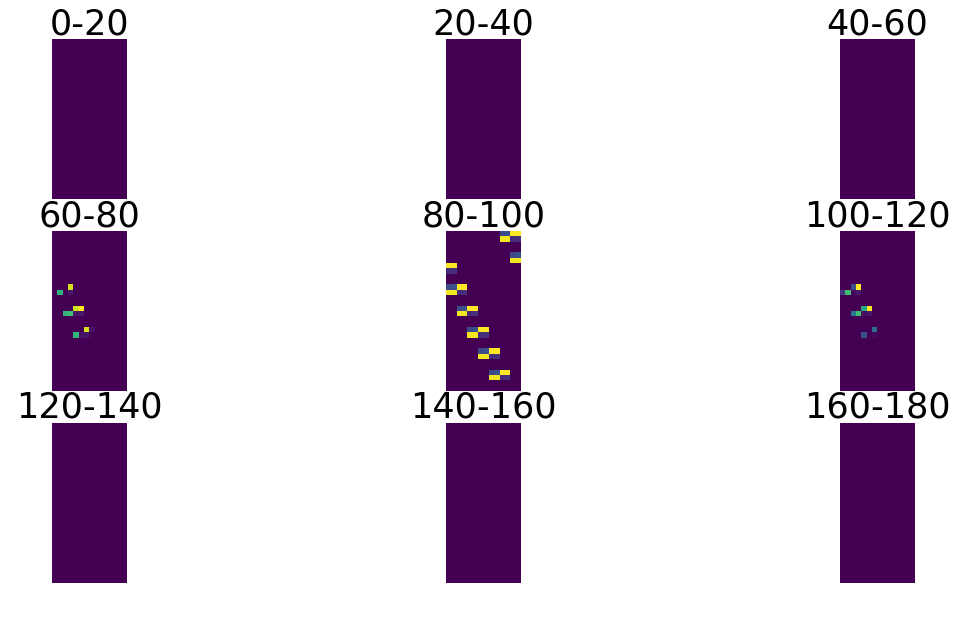

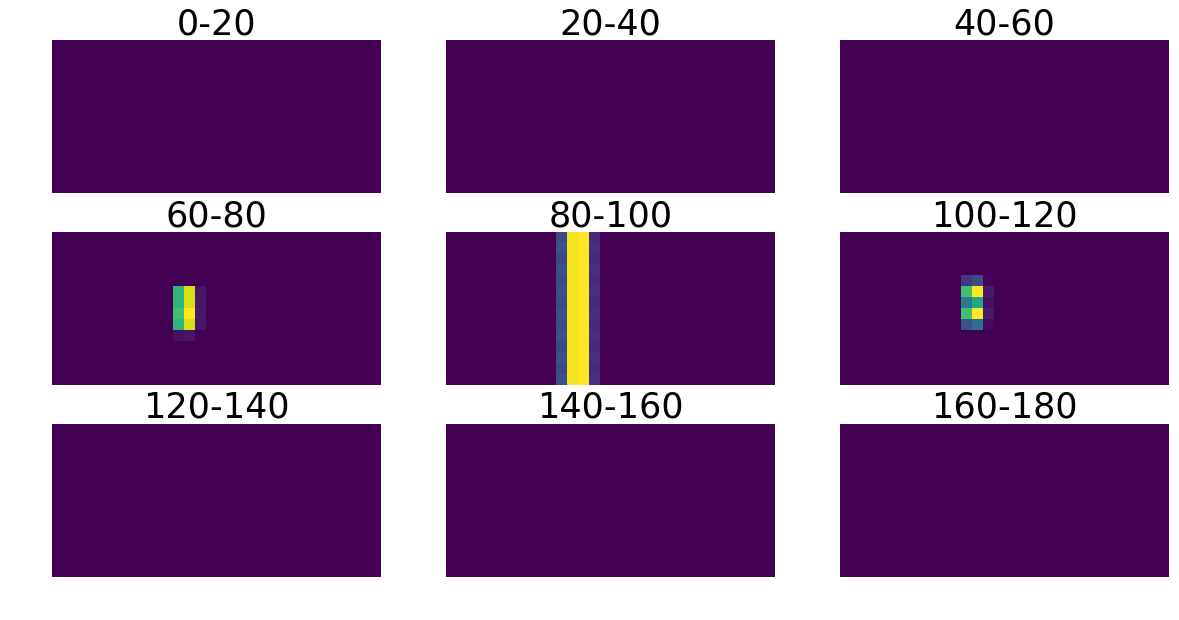

In [7]:
#try.PNG
path='/Users/yaroslavtominin/Desktop/t.png'
path1='/Users/yaroslavtominin/Desktop/eee.jpeg'
img = cv2.imread(path)
plt.imshow(img)
win_size = (64,128) 
block_size = (16,16)
block_stride = (8,8)
cell_size = (8,8)
nbins = 9
deriv_aperture = 1
win_sigma = -1
histogram_norm_type = 0
l2_hys_threshold = 2.0000000000000001e-01
gamma_correction = 0
nlevels = 64
hog = cv2.HOGDescriptor(win_size,block_size,block_stride,cell_size,nbins,deriv_aperture,win_sigma,
                        histogram_norm_type,l2_hys_threshold,gamma_correction,nlevels)
img = cv2.imread(path)
img1 = cv2.imread(path1)
#plt.imshow(img)
win_stride = (8,8)
height, width = img.shape[:2]
locations = [((height-128)//2, (width-64)//2)]
descriptor = hog.compute(img, locations=locations)
descriptor1 = hog.compute(img1, locations=locations)
d=[]
d1=[]
for i in range(0,len(descriptor)):
    d.append(descriptor[i][0])
    d1.append(descriptor1[i][0])
print(descriptor[3])
print(d[3])


hog_new=Reshape_in(d)
hog_new1=Reshape_in1(d)



h=np.array(hog_new)
h1=np.array(hog_new1)




print(h.shape)
subl_nbins(h)
subl_nbins(h1)




In [16]:
print(h[6][11][2])
print(hog_new[0][9][8])
print(d[(7*4+4)*36+9:(7*4+4)*36+18])
print(d)

0.0
0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013323617, 0.2790018, 0.000

In [64]:

def Reshape_in(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array with 14 elem
        for j in range(0,15):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,7):
                b.append(Q[2*j*14*9+k*36+i])
                b.append(Q[2*j*14*9+k*36+i+18])
                c.append(Q[2*j*14*9+k*36+i+9])
                c.append(Q[2*j*14*9+k*36+i+27])
            a.append(b)
            a.append(c)
        RES.append(a)
    return RES
def Reshape_in1(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array with 14 elem
        for j in range(0,15):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,7):
                b.append(Q[2*j*14*9+k*36+i])
                b.append(Q[2*j*14*9+k*36+i+9])
                c.append(Q[2*j*14*9+k*36+i+18])
                c.append(Q[2*j*14*9+k*36+i+27])
            a.append(b)
            a.append(c)
        RES.append(a)
    return RES

